# Case Study: Credit Card Fraud Detection

## Objective

The goal of this case study is to identify fraudulent credit card transactions using machine learning, focusing on Logistic Regression and K-Nearest Neighbors (KNN). Since the dataset is highly imbalanced, we apply techniques to handle class imbalance and improve model accuracy.

## Dataset Overview



   * V1 - V28: Anonymized features generated using PCA for privacy.
   * Time: The time elapsed since the first transaction in seconds.
   * Amount: Transaction value.
   * Class: The target variable (0 for legitimate transactions and 1 for fraudulent transactions).

## Load the Dataset

In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv('./data/creditcard.csv')
print(df.head())
print(df['Class'].value_counts())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

We can already see that there are imbalanced data in the target column i.e class.

## Exploratory Data Analysis (EDA)

### Step 1: Analyze class distribution ( Fraud vs Non Fraud )

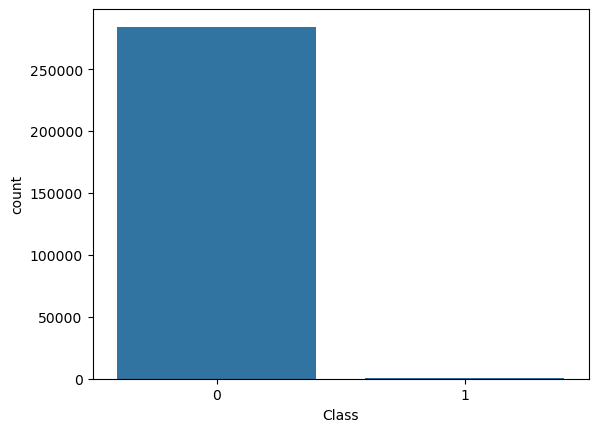

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Class', data=df)

plt.show()

Here we can clearly see that there is imbalance in data i.e most of the data samples are non-fraudulent (value 0) and very few are fraudaulent (value 1)

### Step 2: Distribution of Transaction Amounts

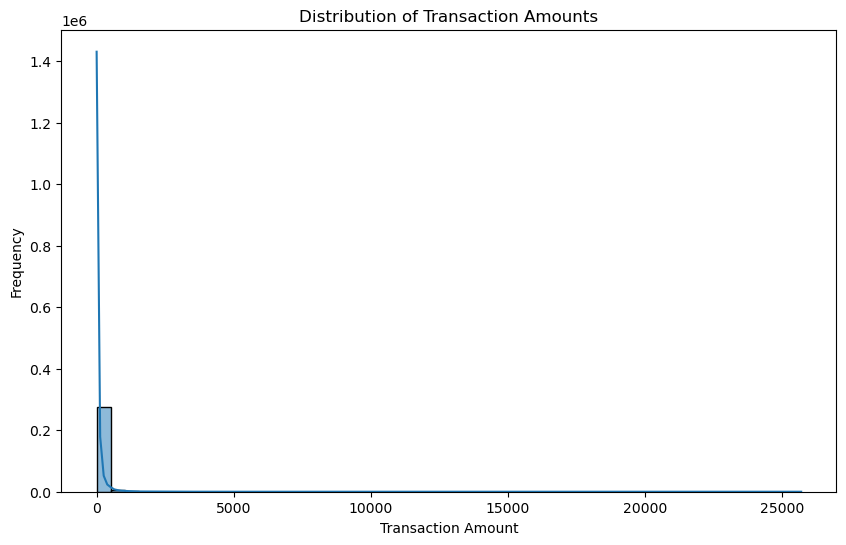

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

The distribution is heavily right-skewed. Most credit card transactions are small.

The transaction amounts are highly skewed, with most values clustered near zero and only a few high-value outliers.

## Preprocessing

### Step 1: Feature Scaling
Since KNN is sensitive to the scale of data, we will standardize our features.

In [10]:
from sklearn.preprocessing import StandardScaler

# Separate input features(X) and target variable (y)
X = df.drop('Class',axis=1)
y = df['Class']

# Standardize features with mean=0 and std=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Learns the mean and std of each column (fit) and then transforms the data (transform) to have mean=0 and std=1

### Step2: Split the Data

In [11]:
from sklearn.model_selection import train_test_split

# Split data into training (80%) and testing (20%) sets
# - random_state ensures reproducible split
# - stratify keeps class proportions same in train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Class Imbalance Handling Techniques

### 1. Random Under Sampling

This technique randomly removing samples from the majority class.

In [13]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random under sampling
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

print(f"Class distribution after Random Under Sampling:\n{y_train_under.value_counts()}")

Class distribution after Random Under Sampling:
Class
0    394
1    394
Name: count, dtype: int64


This method is simple but can lead to loss of important data. It generally results in lower recall but can improve precision.

### 2. Random Over Sampling

This technique randomly duplicates samples in the minority class.

In [15]:
from imblearn.over_sampling import RandomOverSampler

# Apply random over sampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

print(f"Class distribution after Random Over Sampling:\n{y_train_over.value_counts()}")

Class distribution after Random Over Sampling:
Class
0    227451
1    227451
Name: count, dtype: int64


This technique improves recall significantly by duplicating minority instances, but can lead to overfitting.

### 3. SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE generates synthetic samples for the minority class.

In [16]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE sampling
smote_sampler = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote_sampler.fit_resample(X_train, y_train)

print(f'Class distribution before SMOTE: {y_train.value_counts()}')
print(f"Class distribution after SMOTE:\n{y_train_smote.value_counts()}")

Class distribution before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
Class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


SMOTE effectively increases the number of minority samples and generally provides good results in terms of recall and F1 score.

### 4. TOMEK LINKS

Tomek Links removes ambiguous examples from the majority class that are close to the minority class.

In [17]:
from imblearn.under_sampling import TomekLinks

# Apply Tomek Links
tomek_sampler = TomekLinks()
X_train_tomek, y_train_tomek = tomek_sampler.fit_resample(X_train, y_train)

print(f"Class distribution after Tomek Links:\n{y_train_tomek.value_counts()}")

Class distribution after Tomek Links:
Class
0    227434
1       394
Name: count, dtype: int64


This method helps in cleaning the dataset by removing ambiguous samples, leading to clearer decision boundaries.

### 5. SMOTE-TOMEK

This technique combines SMOTE and Tomek Links for better results.

In [18]:
from imblearn.combine import SMOTETomek

# Apply SMOTE-Tomek
smote_tomek_sampler = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek_sampler.fit_resample(X_train, y_train)

print(f"Class distribution after SMOTE-Tomek:\n{y_train_smote_tomek.value_counts()}")

Class distribution after SMOTE-Tomek:
Class
0    227451
1    227451
Name: count, dtype: int64


This combination of techniques generally yields the best performance, leveraging the strengths of both SMOTE and Tomek Links.

###  Recommendations

* Use **Random Under Sampling** or **Tomek Links** when precision is more important.
* Use **SMOTE** or **SMOTE-Tomek** when recall matters more.
* The best approach often depends on the specific context of the business problem and acceptable trade-offs between precision and recall.

## Model Training and Evaluation with Logistics Regression

We will train a Logistic Regression model on each of the balanced datasets and evaluate their performance.

### Step 1: Define a function to train and evaluate model

In [35]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Define the function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    # Initialize the model
    model = LogisticRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) # roc_auc_score gives the area under the ROC curve, showing how well the model separates classes (TPR vs FPR across thresholds).

    return precision, recall, f1, roc_auc

### Step2: Evaluate Models on each Resampled Dataset

In [36]:
# Evaluate on Random Under Sampling
precision_under, recall_under, f1_under, roc_auc_under = train_and_evaluate_model(X_train_under, y_train_under, X_test, y_test)

# Evaluate on Random Over Sampling
precision_over, recall_over, f1_over, roc_auc_over = train_and_evaluate_model(X_train_over, y_train_over, X_test, y_test)

# Evaluate on SMOTE
precision_smote, recall_smote, f1_smote, roc_auc_smote = train_and_evaluate_model(X_train_smote, y_train_smote, X_test, y_test)

# Evaluate on Tomek Links
precision_tomek, recall_tomek, f1_tomek, roc_auc_tomek = train_and_evaluate_model(X_train_tomek, y_train_tomek, X_test, y_test)

# Evaluate on SMOTE-Tomek
precision_smote_tomek, recall_smote_tomek, f1_smote_tomek, roc_auc_smote_tomek = train_and_evaluate_model(X_train_smote_tomek, y_train_smote_tomek, X_test, y_test)

# Store results
results = {
    "Method": ["Random Under Sampling", "Random Over Sampling", "SMOTE", "Tomek Links", "SMOTE-Tomek"],
    "Precision": [precision_under, precision_over, precision_smote, precision_tomek, precision_smote_tomek],
    "Recall": [recall_under, recall_over, recall_smote, recall_tomek, recall_smote_tomek],
    "F1 Score": [f1_under, f1_over, f1_smote, f1_tomek, f1_smote_tomek],
    "ROC AUC": [roc_auc_under, roc_auc_over, roc_auc_smote, roc_auc_tomek, roc_auc_smote_tomek]
}

results_df = pd.DataFrame(results)
print(results_df)

                  Method  Precision    Recall  F1 Score   ROC AUC
0  Random Under Sampling   0.038380  0.918367  0.073680  0.939356
1   Random Over Sampling   0.061350  0.918367  0.115016  0.947076
2                  SMOTE   0.057878  0.918367  0.108893  0.946302
3            Tomek Links   0.828947  0.642857  0.724138  0.821314
4            SMOTE-Tomek   0.057878  0.918367  0.108893  0.946302


**Random Under Sampling (RUS)**
- **Precision:** 0.04 - very low (many false positives).
- **Recall:** 0.92 - almost all frauds are detected.
- **F1 Score:** 0.07 - poor balance due to low precision.
- **ROC AUC:** 0.94 - good at ranking fraud vs non-fraud.
- Good for **catching all frauds**, but **impractical** due to false positives.

**Random Over Sampling (ROS)**
- **Precision:** 0.06 - slightly better than RUS.
- **Recall:** 0.92 - still very high.
- **F1 Score:** 0.11 - better balance than RUS.
- **ROC AUC:** 0.95 - strong.
- Similar to RUS but slightly more balanced.

**SMOTE**
- **Precision:** 0.06, **Recall:** 0.92 (similar to ROS).
- **F1 Score:** 0.11, **ROC AUC:** 0.95.
- Comparable to ROS, no major advantage.

**Tomek Links**
- **Precision:** 0.83 - much higher (fewer false alarms).
- **Recall:** 0.64 - misses more fraud cases.
- **F1 Score:** 0.72 - strongest balance overall.
- **ROC AUC:** 0.82 - lower ranking ability than others.
- Good if **avoiding false alarms is the priority**, but **frauds will be missed**.

**SMOTE-Tomek**
- **Precision:** 0.06, **Recall:** 0.92 (same as SMOTE).
- **F1 Score:** 0.11, **ROC AUC:** 0.95.
- Same recall-focused behavior as SMOTE/ROS.

## Model Training and Evaluation with KNN

We will use KNN as our classifier and evaluate it on each of the resampled datasets using evaluation metrics like precision, recall, F1 score, and ROC-AUC.

### Step 1: Define a function to train and evaluate KNN

In [41]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Define the function to train and evaluate KNN
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    # Initialize the KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the KNN classifier
    knn_classifier.fit(X_train, y_train) # KNN does not actually "train" in the traditional sense, it just stores the training data.
    
    # Predict on the test set
    y_pred = knn_classifier.predict(X_test) # KNN predicts the class of each test instance based on the majority class of its k nearest neighbors in the training set.

    # Calculate the evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    return precision, recall, f1, roc_auc

### Step2: Evaluate Models on each Resampled Dataset

In [42]:
# Evaluate KNN on Random Under Sampling
precision_under, recall_under, f1_under, roc_auc_under = train_and_evaluate_knn(X_train_under, y_train_under, X_test, y_test)

# Evaluate KNN on Random Over Sampling
precision_over, recall_over, f1_over, roc_auc_over = train_and_evaluate_knn(X_train_over, y_train_over, X_test, y_test)

# Evaluate KNN on SMOTE
precision_smote, recall_smote, f1_smote, roc_auc_smote = train_and_evaluate_knn(X_train_smote, y_train_smote, X_test, y_test)

# Evaluate KNN on Tomek Links
precision_tomek, recall_tomek, f1_tomek, roc_auc_tomek = train_and_evaluate_knn(X_train_tomek, y_train_tomek, X_test, y_test)

# Evaluate KNN on SMOTE-Tomek
precision_smote_tomek, recall_smote_tomek, f1_smote_tomek, roc_auc_smote_tomek = train_and_evaluate_knn(X_train_smote_tomek, y_train_smote_tomek, X_test, y_test)

# Store results
results = {
    "Method": ["Random Under Sampling", "Random Over Sampling", "SMOTE", "Tomek Links", "SMOTE-Tomek"],
    "Precision": [precision_under, precision_over, precision_smote, precision_tomek, precision_smote_tomek],
    "Recall": [recall_under, recall_over, recall_smote, recall_tomek, recall_smote_tomek],
    "F1 Score": [f1_under, f1_over, f1_smote, f1_tomek, f1_smote_tomek],
    "ROC AUC": [roc_auc_under, roc_auc_over, roc_auc_smote, roc_auc_tomek, roc_auc_smote_tomek]
}

results_df = pd.DataFrame(results)
print(results_df)

                  Method  Precision    Recall  F1 Score   ROC AUC
0  Random Under Sampling   0.053988  0.897959  0.101852  0.935421
1   Random Over Sampling   0.664062  0.867347  0.752212  0.933295
2                  SMOTE   0.436548  0.877551  0.583051  0.937799
3            Tomek Links   0.918605  0.806122  0.858696  0.903000
4            SMOTE-Tomek   0.436548  0.877551  0.583051  0.937799


- **Random Under Sampling** - Very high recall but extremely low precision and F1. Good at catching frauds, but too many false positives.  
- **Random Over Sampling** - Balanced, with high recall (0.867) and solid precision (0.664). Produces a strong F1 (0.752), making it effective.  
- **SMOTE / SMOTE-Tomek** - Improves recall (0.878) but at the cost of precision (0.437). Useful when recall is prioritized, but leads to more false alarms.  
- **Tomek Links** - Highest precision (0.919) and strong F1 (0.859), but recall (0.806) is lower than oversampling/SMOTE. Good when minimizing false positives is critical.  


## Results and Analysis

The performance metrics of each method can provide insights into how well each technique handles class imbalance:
   * **Precision:** How many predicted positives are actually correct (fewer false positives = higher precision).

   * **Recall:** How many actual positives the model successfully finds (fewer false negatives = higher recall).

   * **F1 Score:** The balance point between precision and recall; higher values mean a better trade-off.

   * **ROC AUC:** The rea under the ROC curve; values closer to 1 show stronger class separation.

### Results Interpretation – Logistic Regression on Credit Card Fraud Data

- **RUS/ROS/SMOTE/SMOTE-Tomek:** Very high recall (catch nearly all frauds) but far too many false alarms. Suitable only if flagged cases go for **manual review**.  
- **Tomek Links:** Lower recall (misses frauds) but **far higher precision and balance**. Best when false alarms are costly (e.g., auto-blocking transactions).  

Overall, Tomek Links gives the most balanced trade-off.
- If the business must catch every fraud, use ROS/SMOTE.
- If minimizing false positives is more important, prefer Tomek Links.

### Results Interpretation – KNN on Credit Card Fraud Data

- **RUS:** Very high recall but extremely low precision, leading to too many false positives. Not practical.  
- **ROS/SMOTE/SMOTE-Tomek:** Good recall with better precision than RUS, but still many false alarms. Useful only if cases can be manually reviewed.  
- **Tomek Links:** Highest precision with strong recall and F1. Provides the best balance between catching frauds and avoiding false positives.  

Overall, **Tomek Links is the most reliable choice** with KNN.  
- If the goal is to maximize fraud detection (catch almost all frauds), use ROS/SMOTE.  
- If reducing false positives is more important, **prefer Tomek Links**.  


## Conclusion

In this study, we addressed class imbalance using techniques like RUS, ROS, SMOTE, Tomek Links, and SMOTE-Tomek, and applied Logistic Regression and KNN to detect fraudulent transactions. Their performance was assessed using precision, recall, F1 score, and ROC AUC metrics.
